
# Welcome

This notebook was generated by the eWaterCycle experiment launcher.

The notebook runs a hydrology model using [grpc4bmi](https://github.com/eWaterCycle/grpc4bmi).



In [1]:
from ewatercycle.parametersetdb import build_from_urls
import numpy as np

In [2]:
# Prepare input
parameter_set = build_from_urls(
    config_format='yaml', config_url='data:text/plain,data: data/PEQ_Hupsel.dat\nparameters:\n  cW: 200\n  cV: 4\n  cG: 5.0e+6\n  cQ: 10\n  cS: 4\n  dG0: 1250\n  cD: 1500\n  aS: 0.01\n  st: loamy_sand\nstart: 367416 # 2011120000\nend: 368904 # 2012020000\nstep: 1\n',
    datafiles_format='svn', datafiles_url='https://github.com/ClaudiaBrauer/WALRUS/trunk/demo/data',
)
parameter_set.save_datafiles('./input')

In [3]:
# Overwrite items in config file
# parameter_set.config['...']['...'] = '...'


In [4]:
# The model inside a BMI Docker container expects the datafiles in the /data/input directory,
# the config file must be adjusted to that

# For PCR-GLOBWB model the input and output directory must be set with
# parameter_set.config['globalOptions']['inputDir'] = '/data/input'
# parameter_set.config['globalOptions']['outputDir'] = '/data/output'

# For wflow model the config file must be set with
# parameter_set.config['model']['configfile'] = '/data/input/config.cfg'

# For Walrus model the data file must be set with
import os;parameter_set.config['data'] = '/data/input/' + os.listdir('input')[0]


In [5]:
# Save config file
parameter_set.save_config('config.cfg')

In [6]:
from grpc4bmi.bmi_client_docker import BmiClientDocker

In [14]:
# Startup model
model = BmiClientDocker(image='ewatercycle/walrus-grpc4bmi', image_port=55555,
                        input_dir="./input",
                        output_dir="./output")
model.initialize('config.cfg')

In [8]:
# Evolve model and capture variable Q at index 0 for each time step
variable = 'Q'
index_of_variable = np.array([0])
variable_overtime = []
tend = model.get_end_time()
while model.get_current_time() < tend:
    model.update()
    value_at_pixel = model.get_value_at_indices(variable, index_of_variable)[0]
    variable_overtime.append((model.get_current_time(), value_at_pixel))


In [9]:
# Plot variable {0}
vals = model.get_value(variable)
unit = model.get_var_units(variable)
shape = model.get_grid_shape(model.get_var_grid(variable))

[]

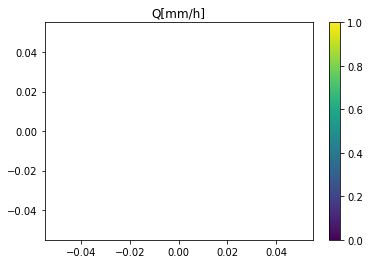

In [12]:
import matplotlib.pyplot as plt
import numpy
import numpy.ma as ma

X, Y = numpy.arange(shape[1]), numpy.arange(shape[0])
Z = numpy.reshape(ma.masked_where(vals == numpy.nan, vals), shape)
plt.title(variable + '[' + unit + ']')
plt.pcolormesh(X,Y,Z)
plt.colorbar()
plt.plot()

In [15]:
# Plot variable {0} at index {1} for each time step
import cftime
from bokeh.plotting import output_notebook, figure, show

output_notebook()

time_unit = model.get_time_units()
p = figure(plot_width=800, plot_height=400, x_axis_type="datetime")
p.xaxis.axis_label = variable + '[' + unit + ']'
p.line([cftime.num2date(d[0], time_unit) for d in variable_overtime], [d[1] for d in variable_overtime] , line_width=2)
show(p)

Loading BokehJS ...

In [16]:
# Stop the Docker container
del model